# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [11]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [12]:
!mkdir data

mkdir: data: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [5]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [00:24, 7.48MB/s]                              
SVHN Testing Set: 64.3MB [00:10, 489KB/s]                             


These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [6]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

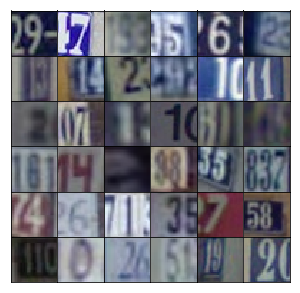

In [7]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [8]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [9]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [23]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [10]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.contrib.layers.fully_connected(z, 4*4*512, activation_fn=None)
        x = tf.reshape(x, (-1, 4, 4, 512))
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(alpha*x, x)
        
        conv1 = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=training)
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=training)
        conv2 = tf.maximum(alpha*conv2, conv2)

        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(conv2, output_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [16]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x = tf.layers.conv2d(x, 64, 5, 2, padding='same')
        x = tf.maximum(alpha*x, x)
        
        conv1 = tf.layers.conv2d(x, 128, 5, 2, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=True)
        conv1 = tf.maximum(alpha*conv1, conv1)

        conv2 = tf.layers.conv2d(x, 256, 5, 2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2)

        flat = tf.reshape(conv2, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [15]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [18]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [19]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [20]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [30]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 5
alpha = 0.001
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/5... Discriminator Loss: 3.0916... Generator Loss: 0.0848
Epoch 1/5... Discriminator Loss: 1.5766... Generator Loss: 0.4997
Epoch 1/5... Discriminator Loss: 0.8636... Generator Loss: 1.0538
Epoch 1/5... Discriminator Loss: 0.7387... Generator Loss: 1.1102
Epoch 1/5... Discriminator Loss: 0.6139... Generator Loss: 1.7782
Epoch 1/5... Discriminator Loss: 0.3951... Generator Loss: 1.6909
Epoch 1/5... Discriminator Loss: 0.3354... Generator Loss: 2.2493
Epoch 1/5... Discriminator Loss: 0.4293... Generator Loss: 2.0078
Epoch 1/5... Discriminator Loss: 0.3176... Generator Loss: 2.2777
Epoch 1/5... Discriminator Loss: 0.3116... Generator Loss: 2.6906


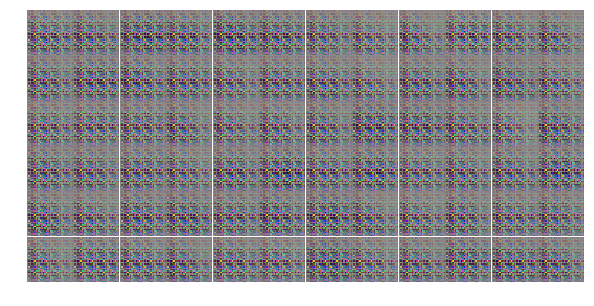

Epoch 1/5... Discriminator Loss: 0.2767... Generator Loss: 2.0470
Epoch 1/5... Discriminator Loss: 0.5016... Generator Loss: 1.6828
Epoch 1/5... Discriminator Loss: 0.8486... Generator Loss: 1.1680
Epoch 1/5... Discriminator Loss: 0.8734... Generator Loss: 1.4305
Epoch 1/5... Discriminator Loss: 0.7130... Generator Loss: 1.4464
Epoch 1/5... Discriminator Loss: 0.6310... Generator Loss: 1.5022
Epoch 1/5... Discriminator Loss: 0.5405... Generator Loss: 1.6083
Epoch 1/5... Discriminator Loss: 0.5067... Generator Loss: 1.6228
Epoch 1/5... Discriminator Loss: 0.5120... Generator Loss: 1.5941
Epoch 1/5... Discriminator Loss: 0.5368... Generator Loss: 1.4169


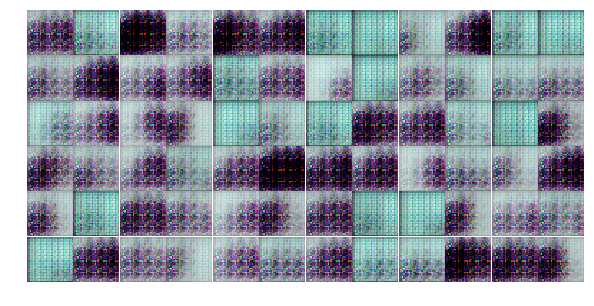

Epoch 1/5... Discriminator Loss: 0.5698... Generator Loss: 1.5149
Epoch 1/5... Discriminator Loss: 0.6302... Generator Loss: 1.4639
Epoch 1/5... Discriminator Loss: 0.7144... Generator Loss: 1.2159
Epoch 1/5... Discriminator Loss: 0.7924... Generator Loss: 1.0703
Epoch 1/5... Discriminator Loss: 0.6978... Generator Loss: 1.1539
Epoch 1/5... Discriminator Loss: 1.0492... Generator Loss: 1.0992
Epoch 1/5... Discriminator Loss: 0.9960... Generator Loss: 0.8371
Epoch 1/5... Discriminator Loss: 0.8303... Generator Loss: 1.2627
Epoch 1/5... Discriminator Loss: 1.1235... Generator Loss: 0.8962
Epoch 1/5... Discriminator Loss: 1.1745... Generator Loss: 0.9303


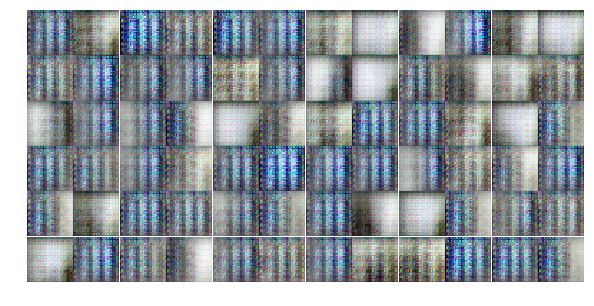

Epoch 1/5... Discriminator Loss: 1.2940... Generator Loss: 0.6633
Epoch 1/5... Discriminator Loss: 0.9266... Generator Loss: 1.0805
Epoch 1/5... Discriminator Loss: 0.9024... Generator Loss: 1.1390
Epoch 1/5... Discriminator Loss: 0.7197... Generator Loss: 1.6588
Epoch 1/5... Discriminator Loss: 1.0332... Generator Loss: 1.0808
Epoch 1/5... Discriminator Loss: 0.9821... Generator Loss: 1.2791
Epoch 1/5... Discriminator Loss: 1.2582... Generator Loss: 0.9187
Epoch 1/5... Discriminator Loss: 1.2498... Generator Loss: 0.9392
Epoch 1/5... Discriminator Loss: 0.9290... Generator Loss: 1.0895
Epoch 1/5... Discriminator Loss: 0.9262... Generator Loss: 1.0752


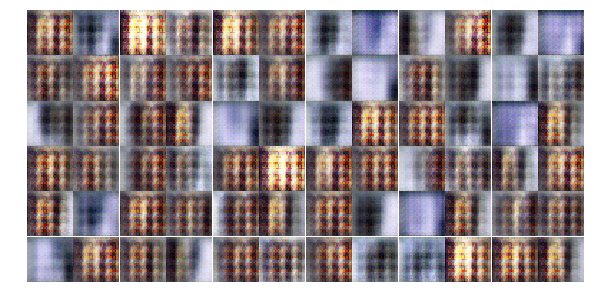

Epoch 1/5... Discriminator Loss: 1.0386... Generator Loss: 0.9677
Epoch 1/5... Discriminator Loss: 1.1224... Generator Loss: 0.8750
Epoch 1/5... Discriminator Loss: 0.9019... Generator Loss: 1.0994
Epoch 1/5... Discriminator Loss: 1.1427... Generator Loss: 0.9678
Epoch 1/5... Discriminator Loss: 0.9965... Generator Loss: 0.9589
Epoch 1/5... Discriminator Loss: 1.1070... Generator Loss: 0.9262
Epoch 1/5... Discriminator Loss: 1.0155... Generator Loss: 0.9712
Epoch 1/5... Discriminator Loss: 0.9705... Generator Loss: 0.9408
Epoch 1/5... Discriminator Loss: 1.0681... Generator Loss: 0.8735
Epoch 1/5... Discriminator Loss: 0.9764... Generator Loss: 0.8527


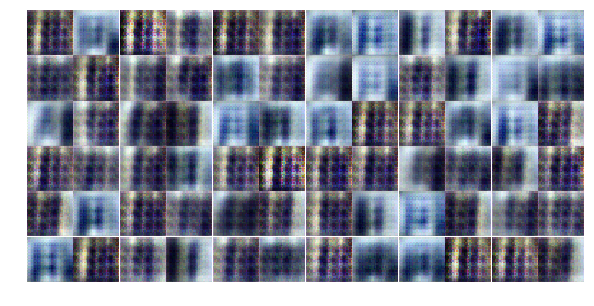

Epoch 1/5... Discriminator Loss: 1.1180... Generator Loss: 0.7573
Epoch 1/5... Discriminator Loss: 0.8746... Generator Loss: 1.0785
Epoch 1/5... Discriminator Loss: 0.9045... Generator Loss: 1.2271
Epoch 1/5... Discriminator Loss: 0.8753... Generator Loss: 1.1103
Epoch 1/5... Discriminator Loss: 0.8273... Generator Loss: 1.2606
Epoch 1/5... Discriminator Loss: 0.8381... Generator Loss: 1.3749
Epoch 1/5... Discriminator Loss: 0.7721... Generator Loss: 1.1262
Epoch 2/5... Discriminator Loss: 1.0170... Generator Loss: 0.9199
Epoch 2/5... Discriminator Loss: 0.9561... Generator Loss: 1.1996
Epoch 2/5... Discriminator Loss: 1.0981... Generator Loss: 0.9414


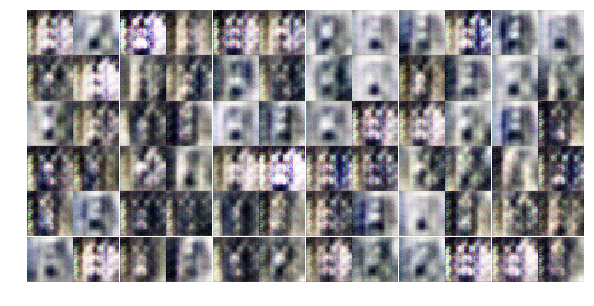

Epoch 2/5... Discriminator Loss: 1.2249... Generator Loss: 0.6714
Epoch 2/5... Discriminator Loss: 0.8742... Generator Loss: 1.1789
Epoch 2/5... Discriminator Loss: 1.3019... Generator Loss: 0.8244
Epoch 2/5... Discriminator Loss: 0.8420... Generator Loss: 1.3851
Epoch 2/5... Discriminator Loss: 0.8769... Generator Loss: 1.0072
Epoch 2/5... Discriminator Loss: 0.8943... Generator Loss: 1.1237
Epoch 2/5... Discriminator Loss: 0.8268... Generator Loss: 1.3941
Epoch 2/5... Discriminator Loss: 0.9987... Generator Loss: 0.8064
Epoch 2/5... Discriminator Loss: 0.9019... Generator Loss: 1.3338
Epoch 2/5... Discriminator Loss: 0.7660... Generator Loss: 1.2843


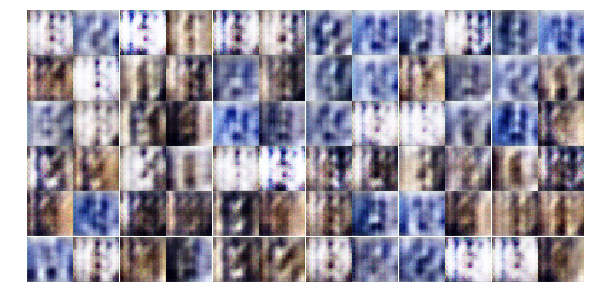

Epoch 2/5... Discriminator Loss: 0.7176... Generator Loss: 1.6041
Epoch 2/5... Discriminator Loss: 0.6425... Generator Loss: 2.8161
Epoch 2/5... Discriminator Loss: 1.0159... Generator Loss: 3.3364
Epoch 2/5... Discriminator Loss: 0.8673... Generator Loss: 1.3250
Epoch 2/5... Discriminator Loss: 0.7939... Generator Loss: 2.2237
Epoch 2/5... Discriminator Loss: 0.8201... Generator Loss: 1.3695
Epoch 2/5... Discriminator Loss: 1.2457... Generator Loss: 0.6013
Epoch 2/5... Discriminator Loss: 1.3639... Generator Loss: 0.4894
Epoch 2/5... Discriminator Loss: 1.2786... Generator Loss: 0.5547
Epoch 2/5... Discriminator Loss: 0.6777... Generator Loss: 1.3264


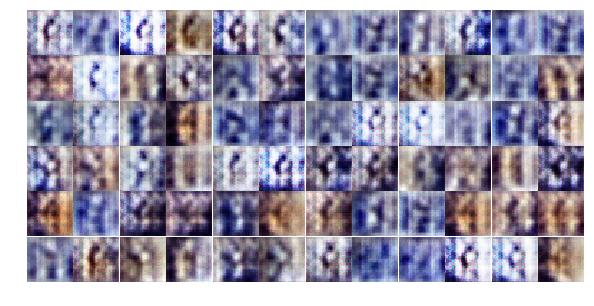

Epoch 2/5... Discriminator Loss: 0.7351... Generator Loss: 1.7080
Epoch 2/5... Discriminator Loss: 1.4235... Generator Loss: 0.4664
Epoch 2/5... Discriminator Loss: 1.5558... Generator Loss: 0.4381
Epoch 2/5... Discriminator Loss: 1.1483... Generator Loss: 0.6196
Epoch 2/5... Discriminator Loss: 0.9182... Generator Loss: 1.4386
Epoch 2/5... Discriminator Loss: 0.7771... Generator Loss: 1.2887
Epoch 2/5... Discriminator Loss: 1.2073... Generator Loss: 0.4744
Epoch 2/5... Discriminator Loss: 0.5969... Generator Loss: 1.6077
Epoch 2/5... Discriminator Loss: 0.7681... Generator Loss: 2.2382
Epoch 2/5... Discriminator Loss: 0.9727... Generator Loss: 0.8511


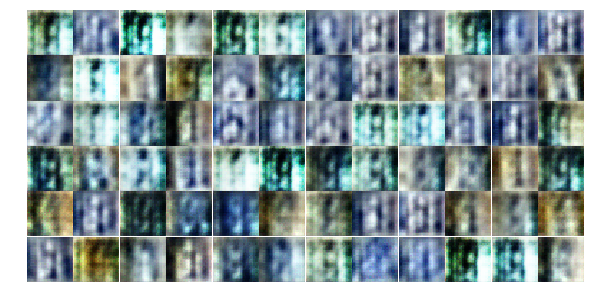

Epoch 2/5... Discriminator Loss: 0.9904... Generator Loss: 1.5575
Epoch 2/5... Discriminator Loss: 0.8455... Generator Loss: 1.0360
Epoch 2/5... Discriminator Loss: 0.5650... Generator Loss: 2.4082
Epoch 2/5... Discriminator Loss: 1.0459... Generator Loss: 0.7294
Epoch 2/5... Discriminator Loss: 0.8724... Generator Loss: 1.1824
Epoch 2/5... Discriminator Loss: 1.5358... Generator Loss: 0.3333
Epoch 2/5... Discriminator Loss: 1.3861... Generator Loss: 0.4716
Epoch 2/5... Discriminator Loss: 0.7473... Generator Loss: 2.2038
Epoch 2/5... Discriminator Loss: 0.7090... Generator Loss: 1.2005
Epoch 2/5... Discriminator Loss: 0.6915... Generator Loss: 1.6764


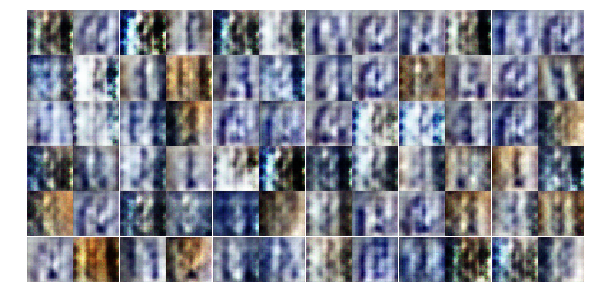

Epoch 2/5... Discriminator Loss: 0.6362... Generator Loss: 1.4821
Epoch 2/5... Discriminator Loss: 1.0620... Generator Loss: 1.3199
Epoch 2/5... Discriminator Loss: 0.9247... Generator Loss: 0.8036
Epoch 2/5... Discriminator Loss: 0.9853... Generator Loss: 0.9864
Epoch 2/5... Discriminator Loss: 0.7981... Generator Loss: 1.5671
Epoch 2/5... Discriminator Loss: 0.9415... Generator Loss: 1.2450
Epoch 2/5... Discriminator Loss: 0.7641... Generator Loss: 2.1227
Epoch 2/5... Discriminator Loss: 0.6799... Generator Loss: 1.8005
Epoch 2/5... Discriminator Loss: 0.4703... Generator Loss: 2.3405
Epoch 2/5... Discriminator Loss: 0.5820... Generator Loss: 3.1809


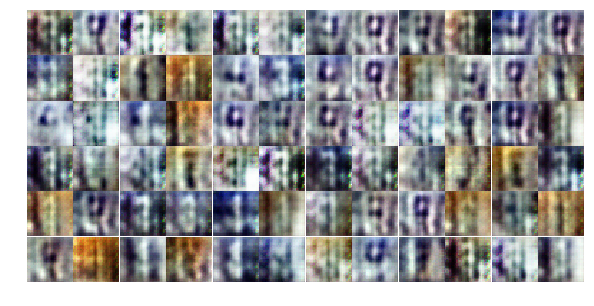

Epoch 2/5... Discriminator Loss: 0.5931... Generator Loss: 2.1629
Epoch 2/5... Discriminator Loss: 0.9919... Generator Loss: 1.7095
Epoch 2/5... Discriminator Loss: 0.8234... Generator Loss: 1.7713
Epoch 2/5... Discriminator Loss: 0.9866... Generator Loss: 0.9982
Epoch 3/5... Discriminator Loss: 0.8161... Generator Loss: 1.4504
Epoch 3/5... Discriminator Loss: 0.8566... Generator Loss: 1.0721
Epoch 3/5... Discriminator Loss: 0.9325... Generator Loss: 1.1589
Epoch 3/5... Discriminator Loss: 0.8353... Generator Loss: 0.9865
Epoch 3/5... Discriminator Loss: 0.7700... Generator Loss: 1.2074
Epoch 3/5... Discriminator Loss: 1.0081... Generator Loss: 1.0640


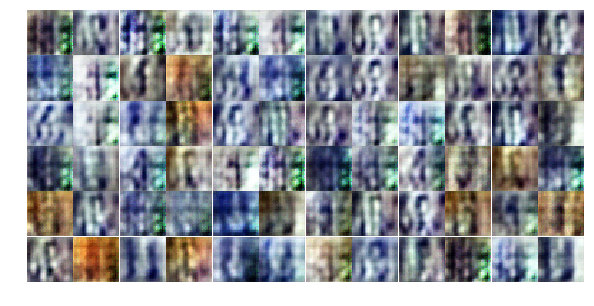

Epoch 3/5... Discriminator Loss: 0.6834... Generator Loss: 1.4377
Epoch 3/5... Discriminator Loss: 0.6837... Generator Loss: 1.9309
Epoch 3/5... Discriminator Loss: 0.7429... Generator Loss: 1.8759
Epoch 3/5... Discriminator Loss: 0.7095... Generator Loss: 1.7551
Epoch 3/5... Discriminator Loss: 0.7490... Generator Loss: 1.5767
Epoch 3/5... Discriminator Loss: 0.8516... Generator Loss: 1.2859
Epoch 3/5... Discriminator Loss: 1.1299... Generator Loss: 0.5447
Epoch 3/5... Discriminator Loss: 0.5392... Generator Loss: 2.3976
Epoch 3/5... Discriminator Loss: 1.1566... Generator Loss: 0.5992
Epoch 3/5... Discriminator Loss: 0.6670... Generator Loss: 1.6921


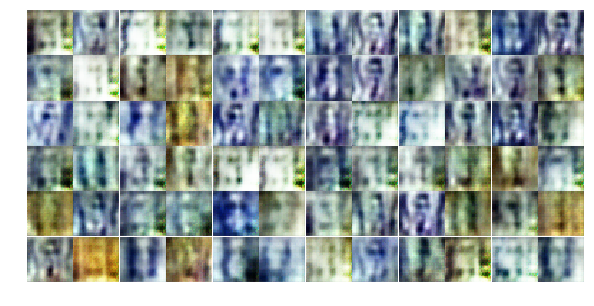

Epoch 3/5... Discriminator Loss: 1.0887... Generator Loss: 0.7498
Epoch 3/5... Discriminator Loss: 0.7360... Generator Loss: 1.5702
Epoch 3/5... Discriminator Loss: 0.9443... Generator Loss: 0.8420
Epoch 3/5... Discriminator Loss: 0.8207... Generator Loss: 1.2104
Epoch 3/5... Discriminator Loss: 0.8425... Generator Loss: 1.2123
Epoch 3/5... Discriminator Loss: 1.0845... Generator Loss: 0.7300
Epoch 3/5... Discriminator Loss: 0.8561... Generator Loss: 1.0825
Epoch 3/5... Discriminator Loss: 1.0686... Generator Loss: 0.9726
Epoch 3/5... Discriminator Loss: 0.7419... Generator Loss: 2.0101
Epoch 3/5... Discriminator Loss: 1.0836... Generator Loss: 0.9599


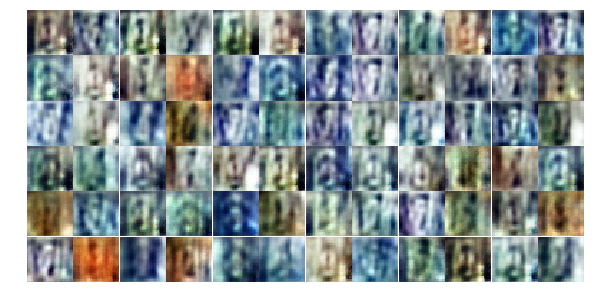

Epoch 3/5... Discriminator Loss: 0.8749... Generator Loss: 1.5345
Epoch 3/5... Discriminator Loss: 1.3057... Generator Loss: 0.5645
Epoch 3/5... Discriminator Loss: 0.9018... Generator Loss: 1.1913
Epoch 3/5... Discriminator Loss: 0.5942... Generator Loss: 2.0953
Epoch 3/5... Discriminator Loss: 1.1525... Generator Loss: 0.7431
Epoch 3/5... Discriminator Loss: 1.0562... Generator Loss: 1.3333
Epoch 3/5... Discriminator Loss: 0.7831... Generator Loss: 2.0125
Epoch 3/5... Discriminator Loss: 0.7962... Generator Loss: 1.4690
Epoch 3/5... Discriminator Loss: 1.1298... Generator Loss: 0.9121
Epoch 3/5... Discriminator Loss: 0.7913... Generator Loss: 1.4894


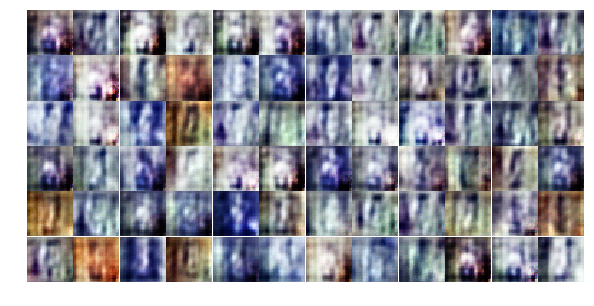

Epoch 3/5... Discriminator Loss: 0.9176... Generator Loss: 1.2364
Epoch 3/5... Discriminator Loss: 0.9959... Generator Loss: 0.8586
Epoch 3/5... Discriminator Loss: 0.9317... Generator Loss: 0.9768
Epoch 3/5... Discriminator Loss: 0.9812... Generator Loss: 1.1542
Epoch 3/5... Discriminator Loss: 1.0804... Generator Loss: 0.7569
Epoch 3/5... Discriminator Loss: 0.7519... Generator Loss: 1.4949
Epoch 3/5... Discriminator Loss: 0.9193... Generator Loss: 1.4972
Epoch 3/5... Discriminator Loss: 1.1495... Generator Loss: 0.9077
Epoch 3/5... Discriminator Loss: 0.9467... Generator Loss: 1.0841
Epoch 3/5... Discriminator Loss: 1.1902... Generator Loss: 0.8138


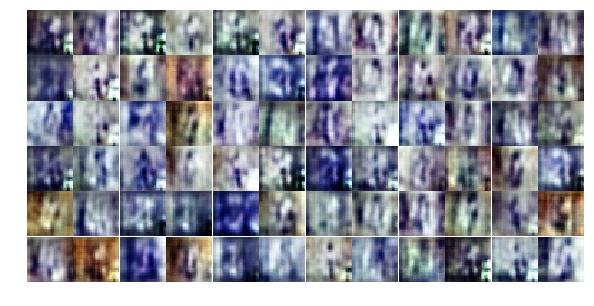

Epoch 3/5... Discriminator Loss: 1.0040... Generator Loss: 1.1979
Epoch 3/5... Discriminator Loss: 1.0136... Generator Loss: 0.8980
Epoch 3/5... Discriminator Loss: 1.0789... Generator Loss: 1.0052
Epoch 3/5... Discriminator Loss: 1.0180... Generator Loss: 0.9499
Epoch 3/5... Discriminator Loss: 1.1553... Generator Loss: 0.8889
Epoch 3/5... Discriminator Loss: 0.9754... Generator Loss: 0.9443
Epoch 3/5... Discriminator Loss: 0.7059... Generator Loss: 1.8862
Epoch 3/5... Discriminator Loss: 0.8363... Generator Loss: 1.4385
Epoch 3/5... Discriminator Loss: 1.0051... Generator Loss: 1.4038
Epoch 3/5... Discriminator Loss: 1.3684... Generator Loss: 0.6088


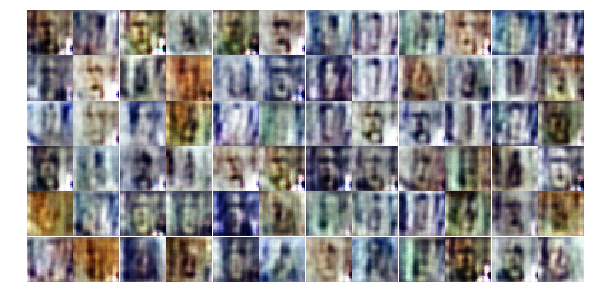

Epoch 3/5... Discriminator Loss: 1.1224... Generator Loss: 1.0825
Epoch 4/5... Discriminator Loss: 0.9974... Generator Loss: 0.8396
Epoch 4/5... Discriminator Loss: 1.1673... Generator Loss: 0.7882
Epoch 4/5... Discriminator Loss: 1.1133... Generator Loss: 0.9627
Epoch 4/5... Discriminator Loss: 1.0816... Generator Loss: 0.9139
Epoch 4/5... Discriminator Loss: 1.0900... Generator Loss: 1.2123
Epoch 4/5... Discriminator Loss: 0.9612... Generator Loss: 1.1103
Epoch 4/5... Discriminator Loss: 1.3447... Generator Loss: 0.9113
Epoch 4/5... Discriminator Loss: 1.0446... Generator Loss: 0.7677
Epoch 4/5... Discriminator Loss: 1.2848... Generator Loss: 0.9475


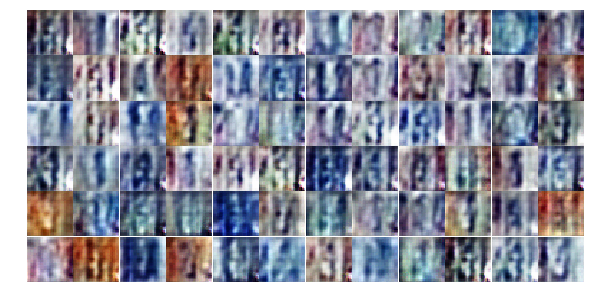

Epoch 4/5... Discriminator Loss: 1.1315... Generator Loss: 1.1693
Epoch 4/5... Discriminator Loss: 1.1449... Generator Loss: 0.8112
Epoch 4/5... Discriminator Loss: 1.3011... Generator Loss: 0.8588
Epoch 4/5... Discriminator Loss: 0.9917... Generator Loss: 1.3542
Epoch 4/5... Discriminator Loss: 1.2031... Generator Loss: 0.6340
Epoch 4/5... Discriminator Loss: 1.0589... Generator Loss: 0.8183
Epoch 4/5... Discriminator Loss: 0.9912... Generator Loss: 0.9857
Epoch 4/5... Discriminator Loss: 1.1053... Generator Loss: 0.8500
Epoch 4/5... Discriminator Loss: 1.1238... Generator Loss: 0.8374
Epoch 4/5... Discriminator Loss: 1.0604... Generator Loss: 0.8556


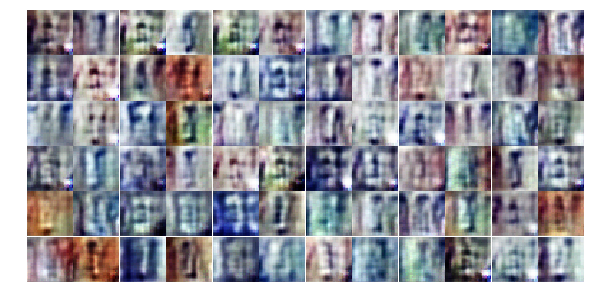

Epoch 4/5... Discriminator Loss: 0.9754... Generator Loss: 1.2228
Epoch 4/5... Discriminator Loss: 0.9123... Generator Loss: 1.2976
Epoch 4/5... Discriminator Loss: 1.1147... Generator Loss: 0.9144
Epoch 4/5... Discriminator Loss: 1.1331... Generator Loss: 0.9399
Epoch 4/5... Discriminator Loss: 0.9186... Generator Loss: 1.1450
Epoch 4/5... Discriminator Loss: 0.9322... Generator Loss: 1.2636
Epoch 4/5... Discriminator Loss: 1.1748... Generator Loss: 0.7330
Epoch 4/5... Discriminator Loss: 1.0642... Generator Loss: 0.9417
Epoch 4/5... Discriminator Loss: 0.8900... Generator Loss: 2.0777
Epoch 4/5... Discriminator Loss: 1.1799... Generator Loss: 0.7650


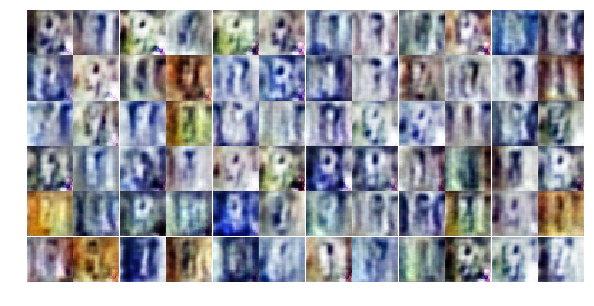

Epoch 4/5... Discriminator Loss: 0.8948... Generator Loss: 1.5319
Epoch 4/5... Discriminator Loss: 1.0957... Generator Loss: 1.1804
Epoch 4/5... Discriminator Loss: 1.0343... Generator Loss: 1.0708
Epoch 4/5... Discriminator Loss: 1.0246... Generator Loss: 1.0773
Epoch 4/5... Discriminator Loss: 0.8221... Generator Loss: 1.4538
Epoch 4/5... Discriminator Loss: 1.0699... Generator Loss: 1.0581
Epoch 4/5... Discriminator Loss: 1.0908... Generator Loss: 0.8685
Epoch 4/5... Discriminator Loss: 0.6609... Generator Loss: 1.9919
Epoch 4/5... Discriminator Loss: 1.2486... Generator Loss: 0.7062
Epoch 4/5... Discriminator Loss: 0.9292... Generator Loss: 1.4138


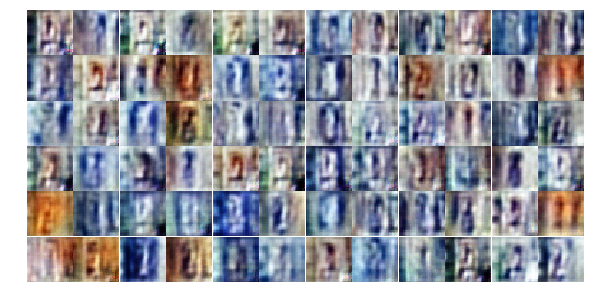

Epoch 4/5... Discriminator Loss: 1.2422... Generator Loss: 0.6372
Epoch 4/5... Discriminator Loss: 1.0971... Generator Loss: 0.9098
Epoch 4/5... Discriminator Loss: 1.1473... Generator Loss: 0.7652
Epoch 4/5... Discriminator Loss: 1.0465... Generator Loss: 1.1146
Epoch 4/5... Discriminator Loss: 1.1004... Generator Loss: 1.0527
Epoch 4/5... Discriminator Loss: 1.2116... Generator Loss: 0.7446
Epoch 4/5... Discriminator Loss: 1.0280... Generator Loss: 1.1066
Epoch 4/5... Discriminator Loss: 1.0887... Generator Loss: 0.8796
Epoch 4/5... Discriminator Loss: 1.1341... Generator Loss: 0.9627
Epoch 4/5... Discriminator Loss: 1.1977... Generator Loss: 0.8364


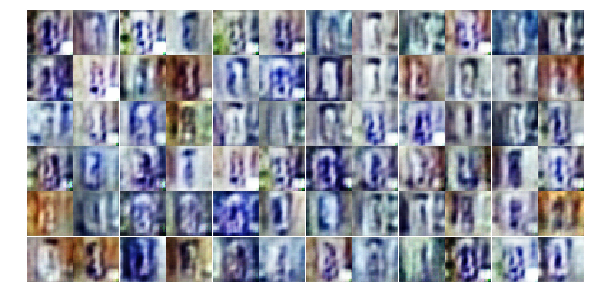

Epoch 4/5... Discriminator Loss: 1.1246... Generator Loss: 0.8630
Epoch 4/5... Discriminator Loss: 1.1593... Generator Loss: 1.1006
Epoch 4/5... Discriminator Loss: 1.1298... Generator Loss: 0.9797
Epoch 4/5... Discriminator Loss: 1.1100... Generator Loss: 0.9365
Epoch 4/5... Discriminator Loss: 1.0987... Generator Loss: 1.0145
Epoch 4/5... Discriminator Loss: 1.2021... Generator Loss: 0.9114
Epoch 4/5... Discriminator Loss: 1.0615... Generator Loss: 0.9467
Epoch 4/5... Discriminator Loss: 0.9663... Generator Loss: 1.0458
Epoch 4/5... Discriminator Loss: 1.2074... Generator Loss: 0.8889
Epoch 5/5... Discriminator Loss: 1.1622... Generator Loss: 0.9771


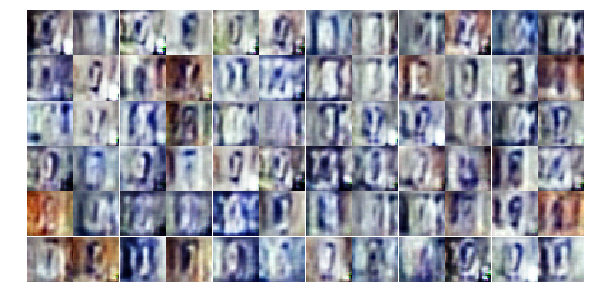

Epoch 5/5... Discriminator Loss: 1.0878... Generator Loss: 0.8888
Epoch 5/5... Discriminator Loss: 1.2184... Generator Loss: 0.7354
Epoch 5/5... Discriminator Loss: 0.8532... Generator Loss: 1.5051
Epoch 5/5... Discriminator Loss: 0.9830... Generator Loss: 1.0443
Epoch 5/5... Discriminator Loss: 0.9763... Generator Loss: 0.9603
Epoch 5/5... Discriminator Loss: 1.0723... Generator Loss: 1.2911
Epoch 5/5... Discriminator Loss: 1.3119... Generator Loss: 0.8501
Epoch 5/5... Discriminator Loss: 1.1625... Generator Loss: 0.8389
Epoch 5/5... Discriminator Loss: 1.0418... Generator Loss: 0.9697
Epoch 5/5... Discriminator Loss: 0.8912... Generator Loss: 1.3103


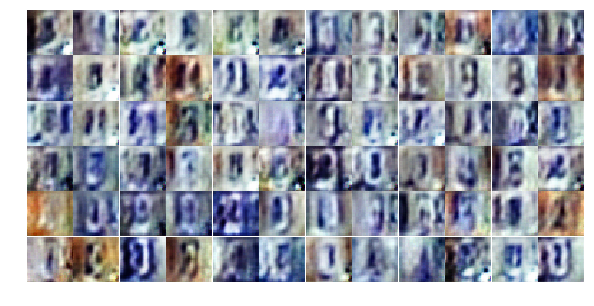

Epoch 5/5... Discriminator Loss: 1.3429... Generator Loss: 0.6361
Epoch 5/5... Discriminator Loss: 1.1436... Generator Loss: 1.0895
Epoch 5/5... Discriminator Loss: 1.0891... Generator Loss: 0.8642
Epoch 5/5... Discriminator Loss: 1.0985... Generator Loss: 1.0491
Epoch 5/5... Discriminator Loss: 1.0494... Generator Loss: 1.1425
Epoch 5/5... Discriminator Loss: 1.4882... Generator Loss: 0.5756
Epoch 5/5... Discriminator Loss: 1.1648... Generator Loss: 0.9728
Epoch 5/5... Discriminator Loss: 1.1140... Generator Loss: 0.9093
Epoch 5/5... Discriminator Loss: 1.2322... Generator Loss: 0.8257
Epoch 5/5... Discriminator Loss: 1.1081... Generator Loss: 1.0723


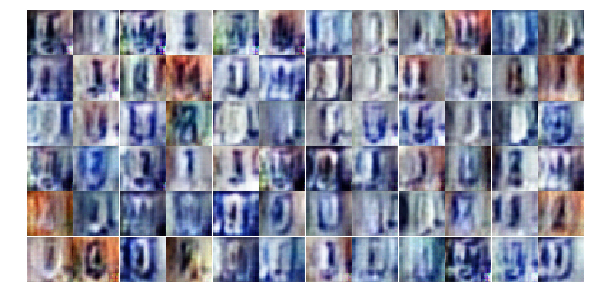

Epoch 5/5... Discriminator Loss: 0.9442... Generator Loss: 1.1759
Epoch 5/5... Discriminator Loss: 0.9865... Generator Loss: 1.3294
Epoch 5/5... Discriminator Loss: 0.9825... Generator Loss: 1.1119
Epoch 5/5... Discriminator Loss: 0.8912... Generator Loss: 1.3851
Epoch 5/5... Discriminator Loss: 1.2094... Generator Loss: 0.7167
Epoch 5/5... Discriminator Loss: 1.0054... Generator Loss: 1.0448
Epoch 5/5... Discriminator Loss: 1.0392... Generator Loss: 0.8781
Epoch 5/5... Discriminator Loss: 0.9821... Generator Loss: 1.0753
Epoch 5/5... Discriminator Loss: 1.0903... Generator Loss: 0.9241
Epoch 5/5... Discriminator Loss: 1.0370... Generator Loss: 1.2427


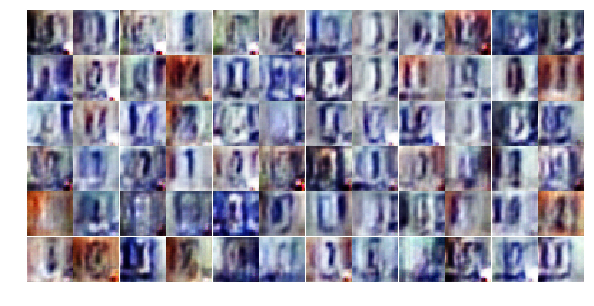

Epoch 5/5... Discriminator Loss: 1.0115... Generator Loss: 1.2794
Epoch 5/5... Discriminator Loss: 1.0179... Generator Loss: 0.8589
Epoch 5/5... Discriminator Loss: 1.0655... Generator Loss: 1.0583
Epoch 5/5... Discriminator Loss: 0.7245... Generator Loss: 1.6298
Epoch 5/5... Discriminator Loss: 1.0900... Generator Loss: 1.1032
Epoch 5/5... Discriminator Loss: 1.1157... Generator Loss: 0.7549
Epoch 5/5... Discriminator Loss: 0.6234... Generator Loss: 2.3204
Epoch 5/5... Discriminator Loss: 1.0870... Generator Loss: 1.0555
Epoch 5/5... Discriminator Loss: 1.0826... Generator Loss: 0.8862
Epoch 5/5... Discriminator Loss: 1.2086... Generator Loss: 0.9066


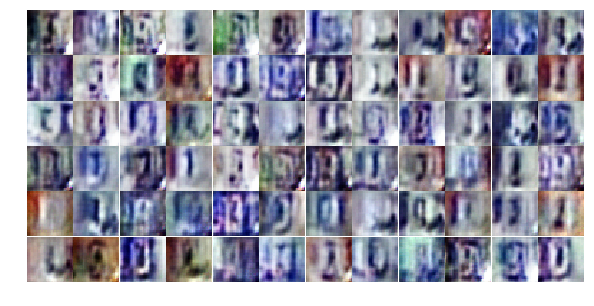

Epoch 5/5... Discriminator Loss: 0.9629... Generator Loss: 1.3732
Epoch 5/5... Discriminator Loss: 0.9943... Generator Loss: 0.9744
Epoch 5/5... Discriminator Loss: 1.3682... Generator Loss: 0.6984
Epoch 5/5... Discriminator Loss: 1.0402... Generator Loss: 0.9719
Epoch 5/5... Discriminator Loss: 1.0954... Generator Loss: 0.9013
Epoch 5/5... Discriminator Loss: 1.2072... Generator Loss: 0.6880
Epoch 5/5... Discriminator Loss: 1.1625... Generator Loss: 0.8305
Epoch 5/5... Discriminator Loss: 1.0180... Generator Loss: 1.1394
Epoch 5/5... Discriminator Loss: 1.0362... Generator Loss: 1.0558
Epoch 5/5... Discriminator Loss: 1.0383... Generator Loss: 1.6384


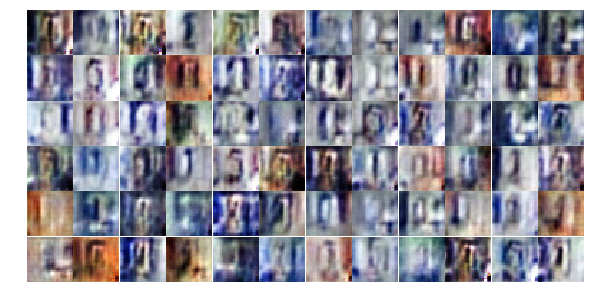

Epoch 5/5... Discriminator Loss: 0.9370... Generator Loss: 1.1360
Epoch 5/5... Discriminator Loss: 0.9360... Generator Loss: 1.1317
Epoch 5/5... Discriminator Loss: 0.8170... Generator Loss: 1.3491
Epoch 5/5... Discriminator Loss: 1.1321... Generator Loss: 0.7376
Epoch 5/5... Discriminator Loss: 1.2141... Generator Loss: 0.8531
Epoch 5/5... Discriminator Loss: 0.9142... Generator Loss: 0.9895


In [31]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

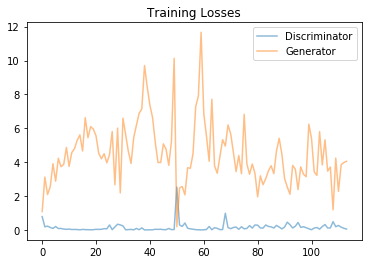

In [26]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

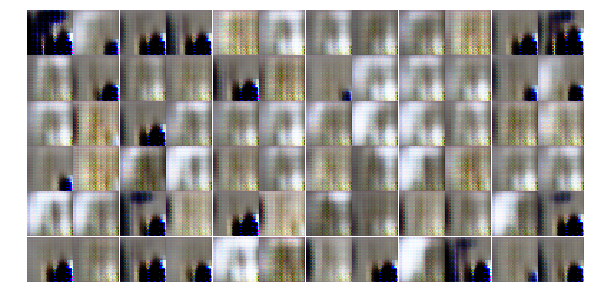

In [27]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))